In [1]:
pip install ultralytics onnxruntime pillow numpy matplotlib opencv-python

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.



[INFO] Benchmarking models (.pt, .onnx, quantized onnx)...

[INFO] Testing PT model:
 - Size: 5.70 MB

image 1/1 /student/vcheruku/Enhance-Data-Diversity-and-Robustness/yolo-for-single-class/images/test/video01_video01_28900_frame_28914_endo.png: 384x640 3 Livers, 10.5ms
Speed: 2.0ms preprocess, 10.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
 - Inference time: 0.1805 seconds
[INFO] Testing ONNX model:
 - Size: 10.97 MB
 - Inference time: 0.0742 seconds
[INFO] Testing ONNX_QUANT model:
 - Size: 3.08 MB
 - Inference time: 0.1243 seconds


/tmp/ipykernel_3188176/1977609231.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(confidences[i])


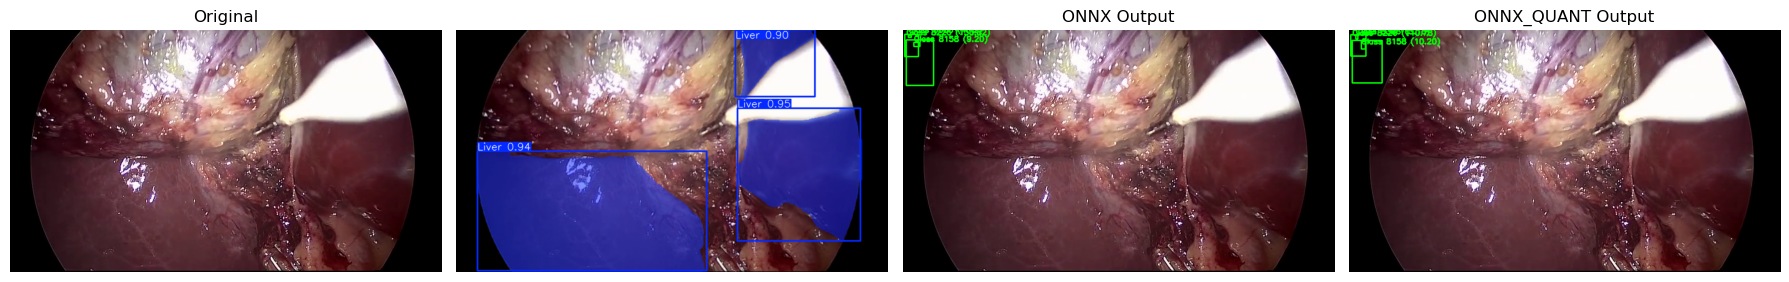

In [19]:
import os
import time
import torch
import onnxruntime as ort
from ultralytics import YOLO
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# === CONFIGURATION ===
model_paths = {
    'pt': '/student/vcheruku/Enhance-Data-Diversity-and-Robustness/yolo-for-single-class/YOLO11/yolo-on-single-object-detection/weights/best.pt',
    'onnx': '/student/vcheruku/Enhance-Data-Diversity-and-Robustness/yolo-for-single-class/YOLO11/yolo-on-single-object-detection/weights/quantization/best.onnx',
    'onnx_quant': '/student/vcheruku/Enhance-Data-Diversity-and-Robustness/yolo-for-single-class/YOLO11/yolo-on-single-object-detection/weights/quantization/best-quant.onnx'
}

image_path = '/student/vcheruku/Enhance-Data-Diversity-and-Robustness/yolo-for-single-class/images/test/video01_video01_28900_frame_28914_endo.png'

def get_file_size(file_path):
    return os.path.getsize(file_path) / (1024 * 1024)

def preprocess_image(image_path, img_size=(640, 640)):
    image = Image.open(image_path).convert('RGB')
    image = image.resize(img_size)
    img = np.array(image).astype(np.float32) / 255.0
    img = img.transpose(2, 0, 1)
    return np.expand_dims(img, axis=0).copy()

def non_maximum_suppression(boxes, confidences, threshold=0.5):
    boxes = boxes.reshape(-1, 4)
    confidences = confidences.flatten()
    indices = cv2.dnn.NMSBoxes(boxes.tolist(), confidences.tolist(), score_threshold=threshold, nms_threshold=0.4)
    return indices.flatten() if indices is not None and len(indices) > 0 else []

def run_pt_model(model_path, image_path):
    model = YOLO(model_path)
    start_time = time.time()
    results = model.predict(image_path, task="segment")
    return results[0], time.time() - start_time

def run_onnx_model(model_path, image_path):
    session = ort.InferenceSession(model_path, providers=["CPUExecutionProvider"])
    img = preprocess_image(image_path)
    input_name = session.get_inputs()[0].name
    start_time = time.time()
    outputs = session.run(None, {input_name: img})
    return outputs[0], time.time() - start_time

def visualize_results(results_dict):
    plt.figure(figsize=(18, 6))
    original = cv2.imread(image_path)
    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    plt.subplot(1, len(results_dict) + 1, 1)
    plt.imshow(original)
    plt.title("Original")
    plt.axis("off")

    for idx, (key, result_obj) in enumerate(results_dict.items(), start=2):
        frame = cv2.imread(image_path)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        plt.subplot(1, len(results_dict) + 1, idx)

        if isinstance(result_obj, np.ndarray):
            try:
                if result_obj.ndim == 3:
                    result_obj = result_obj[0]

                boxes = result_obj[:, :4]
                confidences = result_obj[:, 4:5]
                class_probs = result_obj[:, 5:]

                indices = non_maximum_suppression(boxes, confidences)
                for i in indices:
                    if i >= len(boxes):
                        continue
                    box = boxes[i]
                    x1, y1, x2, y2 = map(int, box)
                    confidence = float(confidences[i])
                    label = int(np.argmax(class_probs[i]))
                    color = (0, 255, 0)
                    cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                    cv2.putText(frame, f"Class {label} ({confidence:.2f})", (x1, y1 - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

                plt.imshow(frame)
                plt.title(f"{key.upper()} Output")

            except Exception as e:
                print(f"[ERROR] {key.upper()} result parsing failed: {e}")
                plt.imshow(frame)
                plt.title(f"{key.upper()} Output (Parse Error)")

        else:
            plotted = result_obj.plot()
            plt.imshow(plotted[:, :, ::-1])

        plt.axis("off")

    plt.tight_layout()
    plt.show()

def benchmark_models():
    print("\n[INFO] Benchmarking models (.pt, .onnx, quantized onnx)...\n")
    results_outputs = {}

    for key, model_path in model_paths.items():
        print(f"[INFO] Testing {key.upper()} model:")
        if not os.path.exists(model_path):
            print(f"[ERROR] Model file not found: {model_path}")
            continue

        size = get_file_size(model_path)
        print(f" - Size: {size:.2f} MB")

        try:
            if key == "pt":
                result, inference_time = run_pt_model(model_path, image_path)
            else:
                result, inference_time = run_onnx_model(model_path, image_path)

            print(f" - Inference time: {inference_time:.4f} seconds")
            results_outputs[key] = result

        except Exception as e:
            print(f"[ERROR] {key.upper()} model inference failed: {e}")

    visualize_results(results_outputs)

# === Run benchmark ===
benchmark_models()
